In [1]:
! rm visualising_the_results/*

# Visualising the results

In this tutorial, we demonstrate the plotting tools built-in to `tupak` and how to extend them. First, we run a simple injection study and return the `result` object.

iter: 4713+250 | bound: 4 | nc: 1 | ncall: 29958 | eff(%): 16.567 | loglstar:   -inf < 6970.440 <    inf | logz: 6953.968 +/-  0.178 | dlogz:  0.000 >  0.100             /home/user1/anaconda2/lib/python2.7/site-packages/dynesty/sampler.py:220: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),


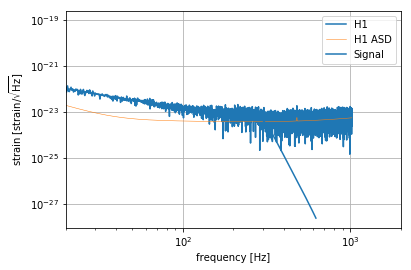

In [2]:
import tupak
%matplotlib inline

time_duration = 4.
sampling_frequency = 2048.
outdir = 'visualising_the_results'
label = 'example'

injection_parameters = dict(mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0, phi_12=1.7, phi_jl=0.3,
                            luminosity_distance=200., iota=0.4, psi=2.659, phase=1.3, geocent_time=1126259642.413,
                            waveform_approximant='IMRPhenomPv2', reference_frequency=50., ra=1.375, dec=-1.2108)

waveform_generator = tupak.waveform_generator.WaveformGenerator(
    sampling_frequency=sampling_frequency, time_duration=time_duration,
    frequency_domain_source_model=tupak.source.lal_binary_black_hole,
    parameters=injection_parameters)
hf_signal = waveform_generator.frequency_domain_strain()

IFOs = [tupak.detector.get_interferometer_with_fake_noise_and_injection(
    'H1', injection_polarizations=hf_signal, injection_parameters=injection_parameters, time_duration=time_duration,
    sampling_frequency=sampling_frequency, outdir=outdir)]

priors = injection_parameters.copy()
priors['mass_1'] = tupak.prior.Uniform(20, 50, 'mass_1')
priors['mass_2'] = tupak.prior.Uniform(20, 50, 'mass_2')
priors['luminosity_distance'] = tupak.prior.Uniform(100, 300, 'luminosity_distance')

likelihood = tupak.likelihood.Likelihood(interferometers=IFOs, waveform_generator=waveform_generator)

result = tupak.sampler.run_sampler(likelihood=likelihood, priors=priors, sampler='dynesty', npoints=100,
                                   injection_parameters=injection_parameters, outdir=outdir, label=label,
                                   walks=5)

plt.show()

In running this code, we already made the first plot! In the function `tupak.detector.get_interferometer_with_fake_noise_and_injection`, the ASD, detector data, and signal are plotted together. This figure is saved under `visualsing_the_results/H1_frequency_domain_data.png`. Note that `visualising_the_result` is our `outdir` where all the output of the run is stored. Let's take a quick look at that directory now:

In [3]:
!ls visualising_the_results/

example_result.h5	      H1_frequency_domain_data.png  prior.txt
H1_frequency_domain_data.dat  H1_psd.dat


## Corner plots

Now lets make some corner plots. You can easily generate a corner plot using `result.plot_corner()` like this:

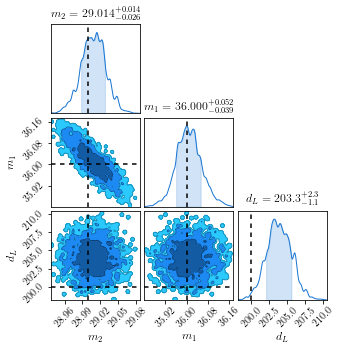

In [4]:
result.plot_corner()
plt.show()

In a notebook, this figure will display. But by default the file is also saved to `visualising_the_result/example_corner.png`. If you change the label to something more descriptive then the `example` here will of course be replaced.

You may also want to plot a subset of the parameters, or perhaps add the `injection_paramters` as lines to check if you recovered them correctly. All this can be done through `plot_corner`. Under the hood, `plot_corner` uses
[chain consumer](https://samreay.github.io/ChainConsumer/index.html), and all the keyword arguments passed to `plot_corner` are passed through to [the `plot` function of chain consumer](https://samreay.github.io/ChainConsumer/chain_api.html#chainconsumer.plotter.Plotter.plot).

### Adding injection parameters to the plot

In the previous plot, you'll notice `tupak` added the injection parameters to the plot by default. You can switch this off by setting `truth=None` when you call `plot_corner`. Or to add different injection parameters to the plot, just pass this as a keyword argument for `truth`. In this example, we just add a line for the luminosity distance by passing a dictionary of the value we want to display.

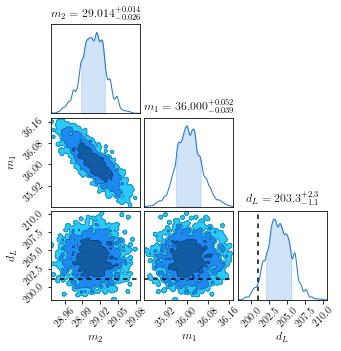

In [5]:
result.plot_corner(truth=dict(luminosity_distance=201))
plt.show()

### Plot a subset of the corner plot

Or, to plot just a subset of parameters, just pass a list of the names you want.

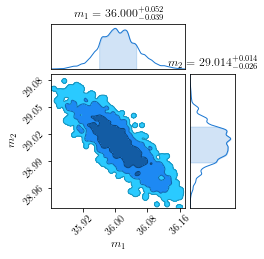

In [6]:
result.plot_corner(parameters=['mass_1', 'mass_2'], filename='{}/subset.png'.format(outdir))
plt.show()

Notice here, we also passed in a keyword argument `filename=`, this overwrites the default filename and instead saves the file as `visualising_the_results/subset.png`. Useful if you want to create lots of different plots. Let's check what the outdir looks like now

In [7]:
!ls visualising_the_results/

example_corner.png  H1_frequency_domain_data.dat  H1_psd.dat  subset.png
example_result.h5   H1_frequency_domain_data.png  prior.txt


## Alternative

If you would prefer to do the plotting yourself, you can get hold of the samples and the ordering as follows and then plot with a different module. Here is an example using the [`corner`](http://corner.readthedocs.io/en/latest/) package

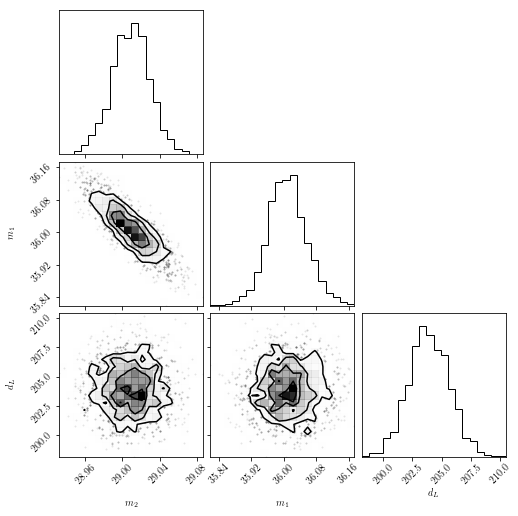

In [8]:
import corner
samples = result.samples
labels = result.parameter_labels
fig = corner.corner(samples, labels=labels)
plt.show()

## Other plots

We also include two other types of plots which may be useful. Again, these are built on chain consumer so you may find it useful to check the [documentation](https://samreay.github.io/ChainConsumer/chain_api.html#plotter-class) to see how these plots can be extednded.

### Walker plots

These plots show the convergence of the sampler during the run:

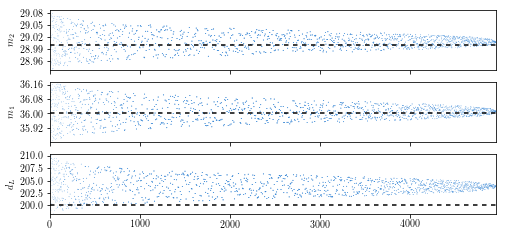

In [9]:
result.plot_walks()
plt.show()

### Distribution plots

These plots just show the 1D histograms for each parameter

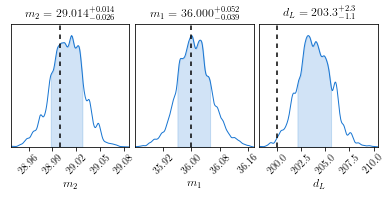

In [10]:
result.plot_distributions()
plt.show()